Predicted Class Index: 1


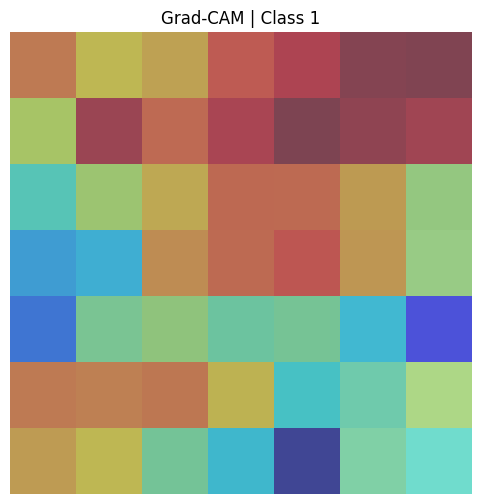

In [ ]:
!pip install torchcam --quiet
import torch
from torchcam.methods import GradCAM
from torchvision.transforms.functional import to_pil_image
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import timm


class HybridFusionModel(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()
        self.cnn = timm.create_model("resnet18", pretrained=False, features_only=True)
        self.swin = timm.create_model("swin_tiny_patch4_window7_224", pretrained=False, features_only=True)
        self.fusion_conv = None
        self.classifier = None
        self.num_classes = num_classes

    def _init_fusion(self, cnn_feat, swin_feat):
        c_cnn = cnn_feat.shape[1]
        c_swin = swin_feat.shape[1]
        total = c_cnn + c_swin
        self.fusion_conv = nn.Sequential(
            nn.Conv2d(total, 512, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, self.num_classes)
        )

    def forward(self, x):
        cnn_feats = self.cnn(x)[-1]
        swin_feats = self.swin(x)[-1]
        if swin_feats.shape[2:] != cnn_feats.shape[2:]:
            swin_feats = F.interpolate(swin_feats, size=cnn_feats.shape[2:], mode="bilinear")
        if self.fusion_conv is None:
            self._init_fusion(cnn_feats, swin_feats)
        fused = torch.cat((cnn_feats, swin_feats), dim=1)
        fused = self.fusion_conv(fused)
        out = self.classifier(fused)
        return out, fused


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridFusionModel(num_classes=6).to(device)
dummy_input = torch.randn(1, 3, 224, 224).to(device)
_ = model(dummy_input)
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/hybrid_fusion_gradcam_best.pth", map_location=device))
model.eval()

target_layer = "fusion_conv.2"
cam_extractor = GradCAM(model, target_layer=target_layer)

img_path = "/content/drive/MyDrive/Dataset2.0/Cardiomegaly/00001364_002.png"
img = Image.open(img_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

input_tensor = transform(img).unsqueeze(0).to(device)

model.zero_grad()
input_tensor.requires_grad_(True)

out, _ = model(input_tensor)
pred_class = out.argmax(dim=1).item()
print(f"Predicted Class Index: {pred_class}")

activation_map = cam_extractor(pred_class, out)[0]

activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())

plt.figure(figsize=(6, 6))
plt.imshow(to_pil_image(input_tensor[0].cpu() * 0.5 + 0.5))  #
plt.imshow(to_pil_image(activation_map), cmap='jet', alpha=0.5)
plt.title(f"Grad-CAM | Class {pred_class}")
plt.axis("off")
plt.show()


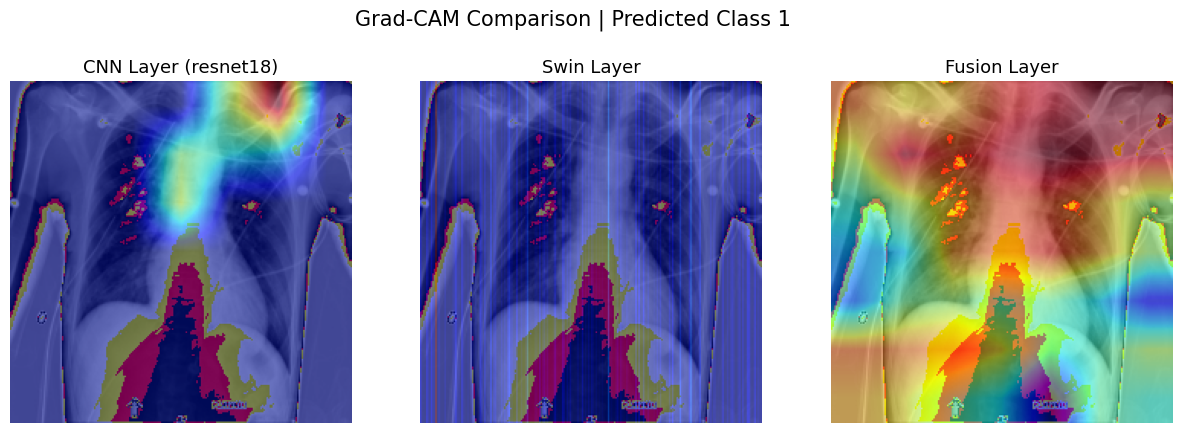

In [ ]:
!pip install torchcam --quiet
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
from torchcam.methods import GradCAM
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
from PIL import Image


class HybridFusionModel(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()
        self.cnn = timm.create_model("resnet18", pretrained=False, features_only=True)
        self.swin = timm.create_model("swin_tiny_patch4_window7_224", pretrained=False, features_only=True)
        self.fusion_conv = None
        self.classifier = None
        self.num_classes = num_classes

    def _init_fusion(self, cnn_feat, swin_feat):
        c_cnn = cnn_feat.shape[1]
        c_swin = swin_feat.shape[1]
        total = c_cnn + c_swin
        self.fusion_conv = nn.Sequential(
            nn.Conv2d(total, 512, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, self.num_classes)
        )

    def forward(self, x):
        cnn_feats = self.cnn(x)[-1]
        swin_feats = self.swin(x)[-1]
        if swin_feats.shape[2:] != cnn_feats.shape[2:]:
            swin_feats = F.interpolate(swin_feats, size=cnn_feats.shape[2:], mode="bilinear")
        if self.fusion_conv is None:
            self._init_fusion(cnn_feats, swin_feats)
        fused = torch.cat((cnn_feats, swin_feats), dim=1)
        fused = self.fusion_conv(fused)
        out = self.classifier(fused)
        return out, fused


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridFusionModel(num_classes=6).to(device)

_ = model(torch.randn(1, 3, 224, 224).to(device))
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/hybrid_fusion_gradcam_best.pth", map_location=device))
model.eval()


img_path = "/content/drive/MyDrive/Dataset2.0/Cardiomegaly/00001364_002.png"
img = Image.open(img_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
input_tensor = transform(img).unsqueeze(0).to(device)
input_tensor.requires_grad_(True)


targets = {
    "CNN Layer (resnet18)": "cnn.layer4.1.act2",
    "Swin Layer": "swin.layers_3.blocks.1.mlp.fc2",
    "Fusion Layer": "fusion_conv.2"
}

plt.figure(figsize=(15, 5))
base_img = to_pil_image(input_tensor[0].cpu() * 0.5 + 0.5)


for i, (name, layer) in enumerate(targets.items()):
    cam_extractor = GradCAM(model, target_layer=layer)

    model.zero_grad()
    out, _ = model(input_tensor)
    pred_class = out.argmax(dim=1).item()

    cam = cam_extractor(pred_class, out)[0]
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    if cam.dim() == 2:
        cam = cam.unsqueeze(0).unsqueeze(0)
    elif cam.dim() == 3:
        cam = cam.unsqueeze(0)
    elif cam.dim() == 4:
        pass
    else:
        raise ValueError(f"Unexpected CAM dimensions: {cam.shape}")

    cam = F.interpolate(cam, size=(224, 224), mode="bilinear", align_corners=False).squeeze()


    plt.subplot(1, 3, i + 1)
    plt.imshow(base_img)
    plt.imshow(to_pil_image(cam.cpu()), cmap="jet", alpha=0.5)
    plt.title(name, fontsize=13)
    plt.axis("off")

plt.suptitle(f"Grad-CAM Comparison | Predicted Class {pred_class}", fontsize=15)
plt.show()


In [ ]:

!pip install torchcam --quiet

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
from torchcam.methods import GradCAM
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
from PIL import Image


DATASET_ROOT = "/content/drive/MyDrive/Dataset2.0"
WEIGHTS_PATH = "/content/drive/MyDrive/Colab Notebooks/hybrid_fusion_gradcam_best.pth"
OUT_DIR = "/mnt/data/gradcam_gallery"  # output dir (will be created)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 6  # adjust if different

# ---------------------------
# Model (same as training)
# ---------------------------
class HybridFusionModel(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()
        self.cnn = timm.create_model("resnet18", pretrained=False, features_only=True)
        self.swin = timm.create_model("swin_tiny_patch4_window7_224", pretrained=False, features_only=True)
        self.fusion_conv = None
        self.classifier = None
        self.num_classes = num_classes

    def _init_fusion(self, cnn_feat, swin_feat):
        c_cnn = cnn_feat.shape[1]
        c_swin = swin_feat.shape[1]
        total = c_cnn + c_swin
        self.fusion_conv = nn.Sequential(
            nn.Conv2d(total, 512, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, self.num_classes)
        )

    def forward(self, x):
        cnn_feats = self.cnn(x)[-1]
        swin_feats = self.swin(x)[-1]
        if swin_feats.shape[2:] != cnn_feats.shape[2:]:
            swin_feats = F.interpolate(swin_feats, size=cnn_feats.shape[2:], mode="bilinear")
        if self.fusion_conv is None:
            self._init_fusion(cnn_feats, swin_feats)
        fused = torch.cat((cnn_feats, swin_feats), dim=1)
        fused = self.fusion_conv(fused)
        out = self.classifier(fused)
        return out, fused

# ---------------------------
# Helpers
# ---------------------------
def find_first_image_in_dir(directory):
    exts = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")
    for fn in sorted(os.listdir(directory)):
        if fn.lower().endswith(exts):
            return os.path.join(directory, fn)
    return None

def ensure_cam_tensor(cam):
    # Normalize cam to [0,1] and ensure (1,1,H,W)
    cam = cam.detach()
    cam = cam - cam.min()
    denom = (cam.max() + 1e-8)
    cam = cam / denom
    if cam.dim() == 2:
        cam = cam.unsqueeze(0).unsqueeze(0)
    elif cam.dim() == 3:
        # could be (C,H,W) or (1,H,W)
        if cam.shape[0] == 1:
            cam = cam.unsqueeze(0)  # (1,1,H,W)
        else:
            cam = cam.unsqueeze(0)  # (1,C,H,W) -> keep C channel
            # if multi-channel, average channels:
            cam = cam.mean(dim=1, keepdim=True)
    elif cam.dim() == 4:
        # (N,C,H,W) -> take first and average channels if C>1
        cam = cam[0:1]
        if cam.shape[1] > 1:
            cam = cam.mean(dim=1, keepdim=True)
    else:
        raise ValueError(f"Unexpected CAM dimensions: {cam.shape}")
    return cam  # shape (1,1,H,W)

# ---------------------------
# Preprocess
# ---------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# ---------------------------
# Load model & weights
# ---------------------------
model = HybridFusionModel(num_classes=NUM_CLASSES).to(DEVICE)
# initialize fusion layers by dummy forward
_ = model(torch.randn(1, 3, 224, 224).to(DEVICE))
model.load_state_dict(torch.load(WEIGHTS_PATH, map_location=DEVICE))
model.eval()

# ---------------------------
# Targets (you may tweak)
# ---------------------------
TARGETS = {
    "CNN Layer (resnet18)": "cnn.layer4.1.act2",             # higher-res CNN activation
    "Swin Layer": "swin.layers_3.blocks.1.mlp.fc2",         # Swin transformer's intermediate
    "Fusion Layer": "fusion_conv.2",                        # final fusion ReLU
}

# ensure output dir
os.makedirs(OUT_DIR, exist_ok=True)

# ---------------------------
# Iterate classes and create gallery
# ---------------------------
class_dirs = sorted([d for d in os.listdir(DATASET_ROOT) if os.path.isdir(os.path.join(DATASET_ROOT, d))])
if len(class_dirs) == 0:
    raise RuntimeError(f"No class subfolders found in {DATASET_ROOT}")

print(f"Found {len(class_dirs)} classes. Generating Grad-CAMs to: {OUT_DIR}")

for cls in class_dirs:
    cls_dir = os.path.join(DATASET_ROOT, cls)
    img_path = find_first_image_in_dir(cls_dir)
    if img_path is None:
        print(f"[skip] no image in {cls_dir}")
        continue

    # load image and tensor
    pil_img = Image.open(img_path).convert("RGB")
    input_tensor = transform(pil_img).unsqueeze(0).to(DEVICE)
    input_tensor.requires_grad_(True)

    # base image for overlay
    base_img = to_pil_image(input_tensor[0].cpu() * 0.5 + 0.5)

    # Prepare plotting grid
    n_cols = len(TARGETS)
    plt.figure(figsize=(5 * n_cols, 5))

    # For each target, create extractor BEFORE forward
    pred_class = None
    for i, (title, layer_name) in enumerate(TARGETS.items()):
        try:
            cam_extractor = GradCAM(model, target_layer=layer_name)
        except Exception as e:
            print(f"[{cls}] Failed to create GradCAM for {layer_name}: {e}")
            # draw blank placeholder
            plt.subplot(1, n_cols, i + 1)
            plt.imshow(base_img)
            plt.title(f"{title}\n(hook fail)")
            plt.axis("off")
            continue

        # forward pass (hook is active)
        model.zero_grad()
        out, _ = model(input_tensor)
        if pred_class is None:
            pred_class = int(out.argmax(dim=1).item())

        # get cam safely
        try:
            cam = cam_extractor(pred_class, out)[0]
            cam = ensure_cam_tensor(cam)  # (1,1,H,W)
            cam = F.interpolate(cam, size=(224, 224), mode="bilinear", align_corners=False)
            cam = cam.squeeze(0).squeeze(0).cpu()  # (224,224)
        except Exception as e:
            print(f"[{cls}] Failed to compute CAM for {layer_name}: {e}")
            plt.subplot(1, n_cols, i + 1)
            plt.imshow(base_img)
            plt.title(f"{title}\n(cam fail)")
            plt.axis("off")
            continue

        # plot
        plt.subplot(1, n_cols, i + 1)
        plt.imshow(base_img)
        plt.imshow(cam, cmap="jet", alpha=0.5)
        plt.title(f"{title}", fontsize=12)
        plt.axis("off")

    plt.suptitle(f"Class: {cls} | Predicted: {pred_class}", fontsize=16)
    out_path = os.path.join(OUT_DIR, f"{cls.replace(' ', '_')}_gradcam.png")
    plt.savefig(out_path, bbox_inches="tight", dpi=150)
    plt.close()
    print(f"[saved] {out_path}")

print("All done, sire. Gallery saved.")


Found 6 classes. Generating Grad-CAMs to: /mnt/data/gradcam_gallery
[saved] /mnt/data/gradcam_gallery/Atelectasis_gradcam.png
[saved] /mnt/data/gradcam_gallery/Cardiomegaly_gradcam.png
[saved] /mnt/data/gradcam_gallery/Consolidation_gradcam.png
[saved] /mnt/data/gradcam_gallery/Nodule_gradcam.png
[saved] /mnt/data/gradcam_gallery/Pneumonia_gradcam.png
[saved] /mnt/data/gradcam_gallery/Pneumothorax_gradcam.png
All done, sire. Gallery saved.


In [ ]:
import shutil

shutil.make_archive("/mnt/data/gradcam_gallery", "zip", "/mnt/data/gradcam_gallery")
print("Zipped successfully ✅ -> gradcam_gallery.zip")


Zipped successfully ✅ -> gradcam_gallery.zip


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p "/content/drive/MyDrive/GradCAM_Gallery"
!cp -r /mnt/data/gradcam_gallery/* "/content/drive/MyDrive/GradCAM_Gallery/"
print("Copied to Google Drive: MyDrive/GradCAM_Gallery ✅")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Copied to Google Drive: MyDrive/GradCAM_Gallery ✅
